# Garbage Classification

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, datasets, models
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


### Training transformers

In [13]:
transform = transforms.Compose([
    transforms.ToTensor()
    ])


### Loading in data

In [14]:
trainset = datasets.ImageFolder('data/enel645_2024f/garbage_data/CVPR_2024_dataset_Test', transform=transform)

In [15]:
print(trainset.classes)

['Black', 'Blue', 'Green', 'TTR']


In [16]:
# Function to get the statistics of a dataset
def get_dataset_stats(data_loader):
    mean = 0.
    std = 0.
    nb_samples = 0.
    for data in data_loader:
        data = data[0] # Get the images to compute the statistics
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples
        
    mean /= nb_samples
    std /= nb_samples
    return mean,std

# functions to show an image
def imshow(img,stats):
    img = img *stats[1] + stats[0]     # unnormalize
    npimg = img.numpy() # convert the tensor back to numpy
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [22]:
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

stats = get_dataset_stats(trainloader)

print('Train Stats:', stats)

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(stats[0],stats[1])])

trainset = datasets.ImageFolder('data/enel645_2024f/garbage_data/CVPR_2024_dataset_Train', transform=transform)
valset = datasets.ImageFolder('data/enel645_2024f/garbage_data/CVPR_2024_dataset_Val', transform=transform)
testset = datasets.ImageFolder('data/enel645_2024f/garbage_data/CVPR_2024_dataset_Test', transform=transform)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

classes = ('Black', 'Blue', 'Green', 'TTR')

Train Stats: (tensor([0.1727, 0.1995, 0.2501]), tensor([1.0412, 1.0579, 1.0905]))


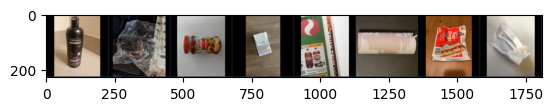

Blue  Black Blue  Black Blue  Blue  Black Blue 


In [23]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:8]), (stats[0][:, None, None], stats[1][:, None, None]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))